```python
def two_site(partial_pressures, K1, K2, k4, K5, k0, T):
    pA, pB, pC = partial_pressures

    k3 = k0 * np.exp(-37000 / (8.314 * T))
    S = (k3 / k4) * K1 * K2 * pA * pB

    # theta_prime and theta_star
    num = 50
    theta_prime = 0.05
    theta_star = 0.05
    
    for _ in range(num):
        theta_star_new = 1 / (1 + K2 * pB + np.sqrt(S * theta_prime / theta_star))
        theta_prime_new = 1 / (1 + K1 * pA + pC / K5 + np.sqrt(S * theta_star / theta_prime))
        theta_star = np.maximum(0, np.minimum(1, theta_star_new))  
        theta_prime = np.maximum(0, np.minimum(1, theta_prime_new))
        
#     print("theta_star:", theta_star)
#     print("theta_prime:", theta_prime)  


    rate = k3 * K1 * K2 * pB * pA * theta_star * theta_prime
    return rate




# Step 3: Objective Function
def objective(params):
    K1, K2, k4, K5, k0 = params
    model_rates = two_site(partial_pressures.T, K1, K2, k4, K5, k0, Temp)
    return np.abs((model_rates - experimental_rates)/experimental_rates) * 100


# Step 4: least_squares optimization

initial_params = [4.6, 100000, 50, 10, 100]  # K1, K2, k3(not included - should be small), k4(fast step), K5, k0
lb = [0, 1, 0, 0, 0]                 # K1, K2, k4, K5, k0
ub = [np.inf, np.inf, np.inf, np.inf, np.inf]
bounds1 = (lb,ub)

result = least_squares(objective, initial_params, bounds=bounds1)
K1n_fit, K2n_fit, k4n_fit, K5n_fit, k0n_fit = result.x

model_rates2 = two_site(partial_pressures.T, K1n_fit, K2n_fit, k4n_fit, K5n_fit, k0n_fit, Temp)
percentage_error2 = np.abs((model_rates2 - experimental_rates) / experimental_rates) * 100


print("\n Model rates 2",model_rates2)
print("\n")
print(K1n_fit)
print(K2n_fit)
print(k4n_fit)
print(K5n_fit)
print("k0: ", k0n_fit)
print("\n")

print("\nPercentage error least squares are :",percentage_error2)
```
https://stackoverflow.com/questions/76603587/non-linear-data-fitting-for-kinetic-data

```
solve {x = 1/(1+A+sqrt(s*y/x)), y = 1/(1+A+B +sqrt(s*x/y))} for x and y
```

https://www.wolframalpha.com/input?i=solve+%7Bx+%3D+1%2F%281%2BA%2Bsqrt%28s*y%2Fx%29%29%2C+y+%3D+1%2F%281%2BA%2BB+%2Bsqrt%28s*x%2Fy%29%29%7D+for+x+and+y

```
jacobian {1/(1+B+sqrt(s*y/x)), 1/(1+A+C +sqrt(s*x/y))} wrt x and y
```

https://www.wolframalpha.com/input?i=jacobian+%7B1%2F%281%2BB%2Bsqrt%28s*y%2Fx%29%29%2C+1%2F%281%2BA%2BC+%2Bsqrt%28s*x%2Fy%29%29%7D+wrt+x+and+y

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize 

$$
((s y)/(2 x^2 sqrt((s y)/x) (B + sqrt((s y)/x) + 1)^2) | -s/(2 x sqrt((s y)/x) (B + sqrt((s y)/x) + 1)^2)
-s/(2 y sqrt((s x)/y) (A + C + sqrt((s x)/y) + 1)^2) | (s x)/(2 y^2 sqrt((s x)/y) (A + C + sqrt((s x)/y) + 1)^2))
$$

In [2]:
class Kinetic:
    
    """Langmuir-Hinshelwood Two-Site Kinetic Model Solver"""
    
    R = 8.314              # J/mol.K
    Ea = 37000             # J/mol
    k1_ = 4.6              # 1 
    k2_ = 100000           # 1
    k4_ = 50               # 1
    k5_ = 10               # 1
    k0_ = 100              # 1
    T = 473.15             # K
    theta_ = [0.9, 0.9]    # 1
    
    @staticmethod
    def k3(k0):
        """Arrhenius estimation for k3"""
        return k0*np.exp(-Kinetic.Ea/(Kinetic.R*Kinetic.T))

    @staticmethod
    def s(p, k1, k2, k4, k5, k0):
        """Partial kinetic rate"""
        k3 = Kinetic.k3(k0)
        return (k1*k2*k3/k4)*p[0]*p[1]
    
    
    @staticmethod
    def system(theta, p, k1, k2, k4, k5, k0):
        """Isothermal coverages system"""
        s = Kinetic.s(p, k1, k2, k4, k5, k0)
        return np.array([
            1/(1 + k2*p[1] + np.sqrt(s*theta[1]/theta[0])) - theta[0],
            1/(1 + k1*p[0] + p[2]/k5 + np.sqrt(s*theta[0]/theta[1])) - theta[1],
        ])
    
    @staticmethod
    #@np.vectorize
    def thetas(p, k1, k2, k4, k5, k0):
        """Isothermal coverages"""
        return optimize.fsolve(
            Kinetic.system,
            Kinetic.theta_,
            args=(p, k1, k2, k4, k5, k0),
            full_output=False
        )
    
    #thetas = np.vectorize(_thetas, excluded=("k1", "k2", "k4", "k5", "k0"))
    
    @staticmethod
    def r(p, k1, k2, k4, k5, k0):
        """Global kinetic rate"""
        k3 = Kinetic.k3(k0)
        theta = Kinetic.thetas(p, k1, k2, k4, k5, k0)
        return (k1*k2*k3)*p[0]*p[1]*theta[0]*theta[1]
    
    @staticmethod
    def solve(p, r, *k_):
        """Global kinetic constants adjustment"""
        return optimize.curve_fit(Kinetic.r, p, r, p0=k_)
    

In [3]:
Kinetic.thetas([0.1, 0.1, 0.1], 5, 1e5, 50, 10, 100)

array([9.92574750e-05, 6.57400005e-01])

In [4]:
df = pd.read_excel("LangmuirData.xlsx")
df

,pa,pb,pc,T,rate
0,0.10,0.11,0.0114,473.15,0.000001
1,0.13,0.11,0.0121,473.15,0.000002
2,0.20,0.11,0.0170,473.15,0.000004
3,0.25,0.11,0.0172,473.15,0.000004
4,0.30,0.11,0.0252,473.15,0.000005
5,0.35,0.11,0.0261,473.15,0.000006
6,0.10,0.16,0.0123,473.15,0.000003
7,0.10,0.20,0.0172,473.15,0.000004
8,0.10,0.22,0.0181,473.15,0.000003
9,0.10,0.33,0.0221,473.15,0.000005


In [5]:
p = df.filter(regex="p").values
r = df["rate"].values

In [6]:
p.shape

(11, 3)

In [7]:
r.shape

(11,)

In [8]:
Kinetic.solve(p, r, (5, 1e5, 50, 10, 100))

TypeError: fsolve: there is a mismatch between the input and output shape of the 'func' argument 'system'.Shape should be (2,) but it is (2, 3).

In [ ]:
def system(t, A, B, C, s):
    return np.array([
        1/(1 + B + np.sqrt(s*t[1]/t[0])) - t[0],
        1/(1 + A + C + np.sqrt(s*t[0]/t[1])) - t[1],
    ])

In [ ]:
optimize.fsolve(system, [0.05, 0.05], args=(10, 20, 30, 0.5), full_output=False)

In [9]:
xlin = np.linspace(0.0001, 1, 200)
ylin = np.linspace(0.0001, 1, 200)

In [10]:
X, Y = np.meshgrid(xlin, ylin)

In [268]:
s = 100
Cx = (X + np.sqrt(s*X*Y) - 1)/X
Cy = (Y + np.sqrt(s*X*Y) - 1)/Y
L = np.arange(0, 26, 1)
#L = np.linspace(0, 1, 26)
#L = np.logspace(-3, 4, 21, base=2)

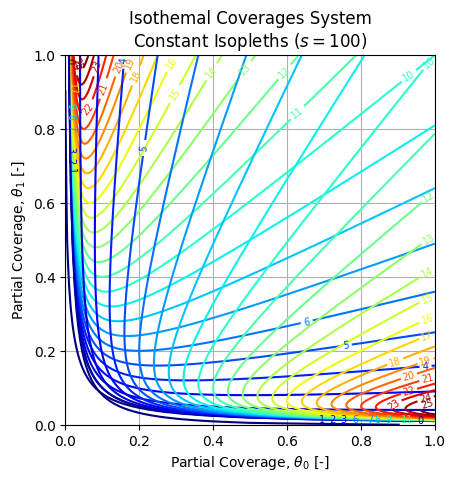

In [275]:
fig, axe = plt.subplots()
xlabels = axe.contour(X, Y, Cx, L, cmap="jet")
axe.clabel(xlabels, xlabels.levels, inline=True, fontsize=7)
ylabels = axe.contour(X, Y, Cy, L, cmap="jet")
axe.clabel(ylabels, ylabels.levels, inline=True, fontsize=7)
#axe.set_xscale("log")
#axe.set_yscale("log")
axe.set_title("Isothemal Coverages System\nConstant Isopleths ($s={}$)".format(s))
axe.set_xlabel(r"Partial Coverage, $\theta_0$ [-]")
axe.set_ylabel(r"Partial Coverage, $\theta_1$ [-]")
axe.set_aspect("equal")
axe.set_xlim([0, 1])
axe.set_ylim([0, 1])
axe.grid()